This notebok is made wrt. Time series forecasting notebook from Tensorflow https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/time_series.ipynb

In [99]:
import datetime
import os

import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import seaborn as sns

import IPython
import IPython.display

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.optimizers import Adam



In [100]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


# Load the data


In [101]:

path = "/home/guts/Documents/accel_data/merged_data.csv"
merged_data = pd.read_csv(path)
merged_data.index = pd.to_datetime(merged_data['Timestamp'])
merged_data.drop('Timestamp', axis=1, inplace=True)
print(merged_data.head())


                     Linear x  Linear y  Linear z  Filtered x  Filtered y  \
Timestamp                                                                   
2024-08-23 14:24:45     -0.08      0.01      0.14   -0.149835    0.008999   
2024-08-23 14:24:53     -0.14     -0.01      0.15   -0.305458   -0.085572   
2024-08-23 14:25:05     -0.10      0.03      0.10   -0.296480    0.041919   
2024-08-23 14:25:09     -0.05      0.11     -0.15   -0.257574   -0.110112   
2024-08-23 14:25:14     -0.05      0.01      0.17   -0.142054   -0.128069   

                     Filtered z  Angular x  Angular y  Angular z  
Timestamp                                                         
2024-08-23 14:24:45  -10.120889   0.006762  -0.004553   0.004431  
2024-08-23 14:24:53  -10.058042  -0.004956  -0.005618  -0.003025  
2024-08-23 14:25:05  -10.014946   0.002501   0.010361   0.005497  
2024-08-23 14:25:09  -10.016742   0.005697  -0.014140  -0.004091  
2024-08-23 14:25:14   -9.561244  -0.008151   0.007165   0.

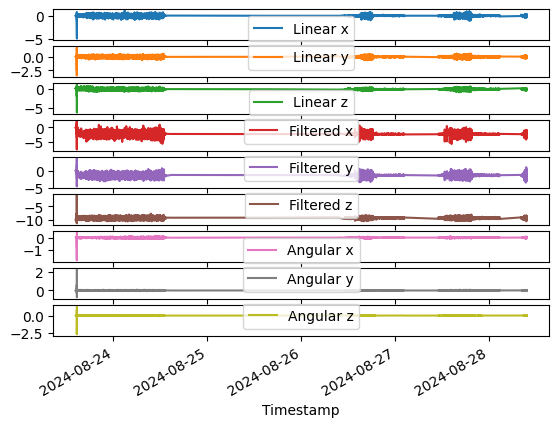

In [102]:
# Plot the data
_ = merged_data.plot(subplots=True)

In [103]:
merged_data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Linear x,49200.0,-0.033482,0.124850,-4.950000,-0.090000,-0.030000,0.020000,1.070000
Linear y,49200.0,-0.015098,0.091632,-3.450000,-0.060000,-0.010000,0.030000,1.690000
Linear z,49200.0,-0.131356,0.124917,-6.110000,-0.190000,-0.140000,-0.080000,1.070000
Filtered x,49200.0,-2.333292,0.466675,-7.777762,-2.565585,-2.338734,-2.101708,2.103707
Filtered y,49200.0,-1.327841,0.380126,-4.624979,-1.546633,-1.324571,-1.110290,3.660755
Filtered z,49200.0,-9.331263,0.323590,-11.302427,-9.623494,-9.220670,-9.107543,-0.996586
Angular x,49200.0,-0.001468,0.018634,-1.822297,-0.009217,-0.001760,0.006762,0.423281
Angular y,49200.0,0.001607,0.018136,-0.721476,-0.006683,0.001839,0.009295,2.250612
Angular z,49200.0,0.000587,0.019877,-2.661925,-0.007286,0.000170,0.008693,1.337077


# Feature engineering


In [104]:

timestamp_s = merged_data.index.map(pd.Timestamp.timestamp)
# secondds in a :
minute = 60
hour = minute*60
day = hour*24
week = 7*day

merged_data['sin_minute'] = np.sin(2*np.pi*timestamp_s/minute)
merged_data['cos_minute'] = np.cos(2*np.pi*timestamp_s/minute)

merged_data['sin_hour'] = np.sin(2*np.pi*timestamp_s/hour)
merged_data['cos_hour'] = np.cos(2*np.pi*timestamp_s/hour)

merged_data['sin_day'] = np.sin(2*np.pi*timestamp_s/day)
merged_data['cos_day'] = np.cos(2*np.pi*timestamp_s/day)  

Text(0.5, 1.0, 'Time of minute signal')

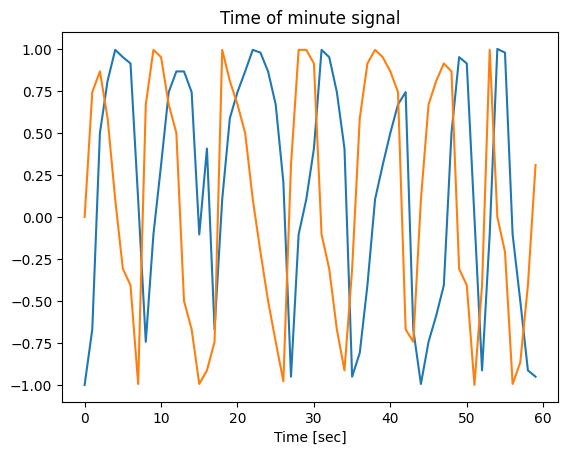

In [105]:
plt.plot(np.array(merged_data['sin_minute'])[0:60])
plt.plot(np.array(merged_data['cos_minute'])[0:60])
plt.xlabel('Time [sec]')
plt.title('Time of minute signal')

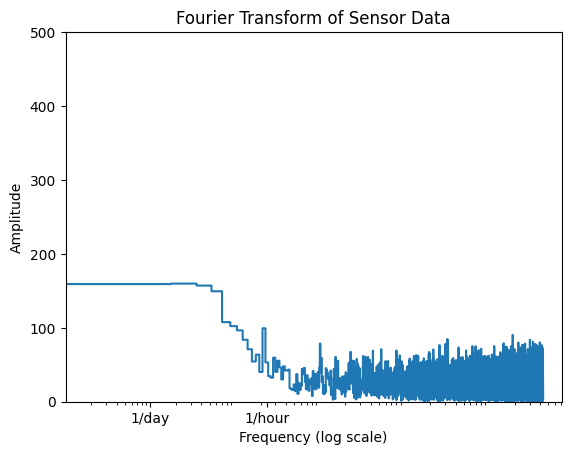

In [106]:
# FFT
fft = tf.signal.rfft(merged_data['Linear x'])
f_per_dataset = np.arange(0, len(fft))

# Number of samples and total duration (in seconds)
n_samples_s = len(merged_data['Linear x'])  # Total number of samples
seconds_per_day = 24 * 60 * 60  # Seconds in a day
hours_per_day = 24  # Hours in a day

# Calculate the dataset's duration in days
days_per_dataset = n_samples_s / seconds_per_day

# Convert frequencies to cycles per day
f_per_day = f_per_dataset / days_per_dataset

# Plotting
plt.step(f_per_day, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 500)  # Adjust for your amplitude range
plt.xlim([0.1, max(plt.xlim())])

# Add X-ticks for "1/day" and "1/hour"
plt.xticks([1, 24], labels=['1/day', '1/hour'])

# Labels
plt.xlabel('Frequency (log scale)')
plt.ylabel('Amplitude')
plt.title('Fourier Transform of Sensor Data')

# Show the plot
plt.show()


## Split the data

In [107]:
column_indices = {name: i for i, name in enumerate(merged_data.columns)}

n = len(merged_data)
train_data = merged_data[0:int(n*0.7)]
val_data = merged_data[int(n*0.7):int(n*0.9)]
test_data = merged_data[int(n*0.9):]

num_features = merged_data.shape[1]


## Normalize the data


In [108]:

train_mean = train_data.mean()
train_std = train_data.std()


train_data = (train_data - train_mean) / train_std
val_data = (val_data - train_mean) / train_std
test_data = (test_data - train_mean) / train_std



/tmp/ipykernel_29183/857531870.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = ax.set_xticklabels(merged_data.keys(), rotation=90)


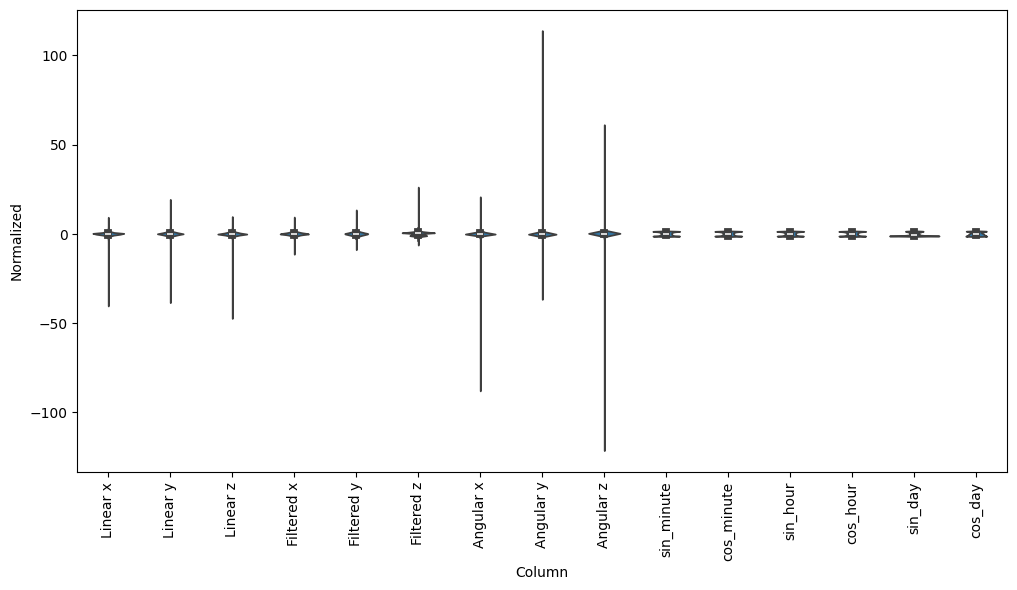

In [109]:
merged_data_std = (merged_data - train_mean) / train_std
merged_data_std = merged_data_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=merged_data_std)
_ = ax.set_xticklabels(merged_data.keys(), rotation=90)

# Datta Windwing

In [110]:
# Idexes and offsets
class WindowGenerator:
    def __init__(self, input_width, label_width, shift, train_df=train_data,val_df=val_data, test_df=test_data, label_columns=None):
        
        # Store the raw data
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in 
                                          enumerate(label_columns)}

        self.column_indices = {name: i for i, name in 
                               enumerate(train_df.columns)}

        # Work out the window parameters
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])
    

In [111]:
w1 = WindowGenerator(input_width=500, label_width=1, shift=500, label_columns=['Linear x'])
w1

Total window size: 1000
Input indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236

In [112]:
# Split the window

def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
        labels = tf.stack([labels[:, :, self.column_indices[name]] for name in self.label_columns], axis=-1)

    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

WindowGenerator.split_window = split_window

In [113]:
# Stack three slices, the length of the total window:

window = tf.stack([np.array(train_data[:w1.total_window_size]),
                   np.array(train_data[100:100+w1.total_window_size]),
                   np.array(train_data[200:200+w1.total_window_size])])

inputs, labels = w1.split_window(window)    

print('Window shape: ', window.shape)
print('Inputs shape: ', inputs.shape)
print('Labels shape: ', labels.shape)

Window shape:  (3, 1000, 15)
Inputs shape:  (3, 500, 15)
Labels shape:  (3, 1, 1)


In [114]:
# Plot the data

w1.example = inputs, labels

In [115]:

def plot(self, model=None, plot_col='Linear x', max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
        plt.subplot(max_n, 1, n+1)
        plt.ylabel(f'{plot_col} [normed]')
        plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                 label='Inputs', marker='.', zorder=-10)
        
        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index

        if label_col_index is None:
            continue

        plt.scatter(self.label_indices, labels[n, :, label_col_index],
                    edgecolors='k', label='Labels', c='#2ca02c', s=64)
        
        if model is not None:
            predictions = model(inputs)
            plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                        marker='X', edgecolors='k', label='Predictions',
                        c='#ff7f0e', s=64)
            
        if n == 0:
            plt.legend()

    plt.xlabel('Time [s]')

WindowGenerator.plot = plot

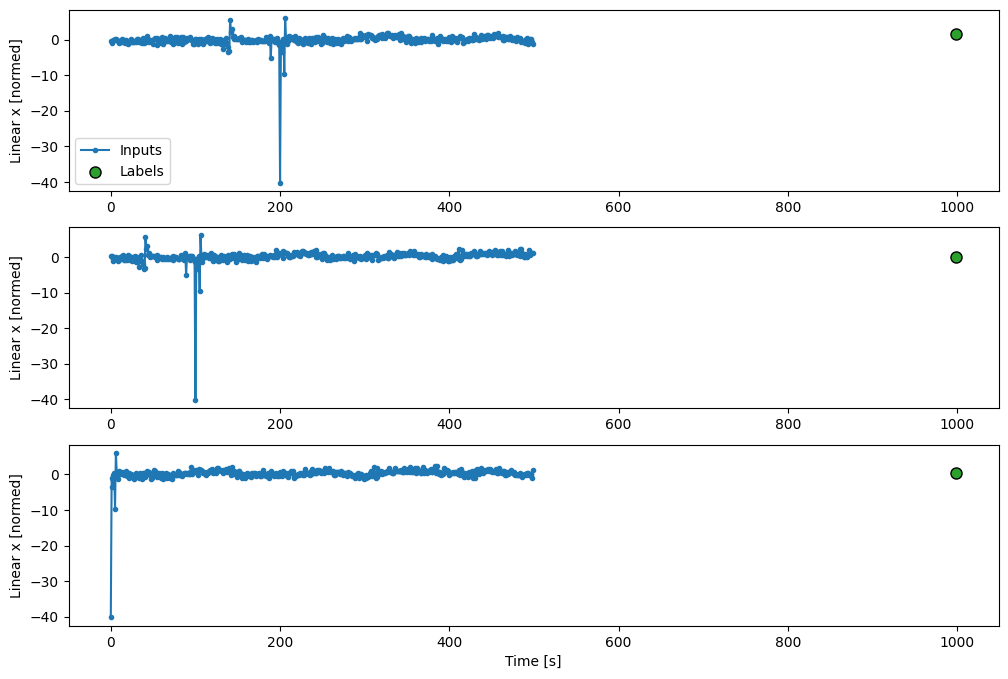

In [116]:
w1.plot()

In [117]:
# Create the dataset

def make_dataset(self, data):   
    data = np.array(data, dtype=np.float16)
    ds  = tf.keras.utils.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=False,
        batch_size=32,)
    ds = ds.map(self.split_window)
    return ds

WindowGenerator.make_dataset = make_dataset

In [118]:
@property
def train(self):
    return self.make_dataset(self.train_df)

@property
def val(self):
    return self.make_dataset(self.val_df)

@property
def test(self):
    return self.make_dataset(self.test_df)

@property
def example(self):
    result = getattr(self, '_example', None)
    if result is None:
        result = next(iter(self.train))
        self._example = result
    return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example


In [119]:
w1.train.element_spec


(TensorSpec(shape=(None, 500, 15), dtype=tf.float16, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float16, name=None))

In [120]:
for inputs, labels in w1.train.take(1):
    print(f'Inputs shape (batch, time, features): {inputs.shape}')
    print(f'Labels shape (batch, time, features): {labels.shape}')

Inputs shape (batch, time, features): (32, 500, 15)
Labels shape (batch, time, features): (32, 1, 1)


2024-10-10 16:53:03.521572: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [121]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['Linear x'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['Linear x']

In [122]:
for example_inputs, example_labels in single_step_window.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 15)
Labels shape (batch, time, features): (32, 1, 1)


In [123]:
wide_window = WindowGenerator(
    input_width=100, label_width=100, shift=1,
    label_columns=['Linear x'])

wide_window

Total window size: 101
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97 98 99]
Label indices: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100]
Label column name(s): ['Linear x']

In [124]:
# Window Generator for Convolutional Neural Network
CONV_WIDTH = 3
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['Linear x'])

In [125]:
# Window Generator for Wide Convolutional Neural Network

LABEL_WIDTH = 100
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['Linear x'])

wide_conv_window

Total window size: 103
Input indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101]
Label indices: [  3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18  19  20
  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38
  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56
  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74
  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92
  93  94  95  96  97  98  99 100 101 102]
Label column name(s): ['Linear x']

In [126]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [127]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (32, 100, 15)
Output shape: (32, 100, 1)


In [128]:
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

305/305 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 1.0163 - mean_absolute_error: 0.6371


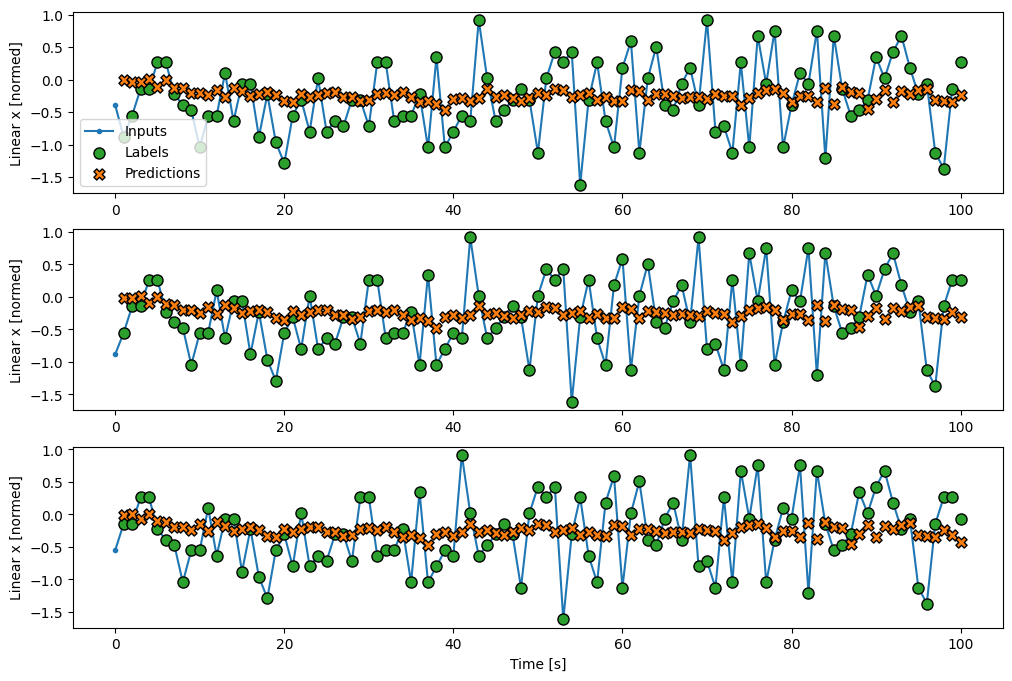

In [129]:
wide_window.plot(lstm_model)

## Multi Output models

In [130]:
single_step_window = WindowGenerator(
    # `WindowGenerator` returns all features as labels if you
    # don't set the `label_columns` argument.
    input_width=1, label_width=1, shift=1)

wide_window = WindowGenerator(
    input_width=100, label_width=100, shift=1)

for example_inputs, example_labels in wide_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')


Inputs shape (batch, time, features): (32, 100, 15)
Labels shape (batch, time, features): (32, 100, 15)


In [131]:
%%time
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1)

lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=num_features)
])

history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate( wide_window.val, return_dict=True)
performance['LSTM'] = lstm_model.evaluate( wide_window.test, verbose=0, return_dict=True)

print()


307/307 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4839 - mean_absolute_error: 0.4194

CPU times: user 3min 6s, sys: 25.6 s, total: 3min 31s
Wall time: 1min 35s


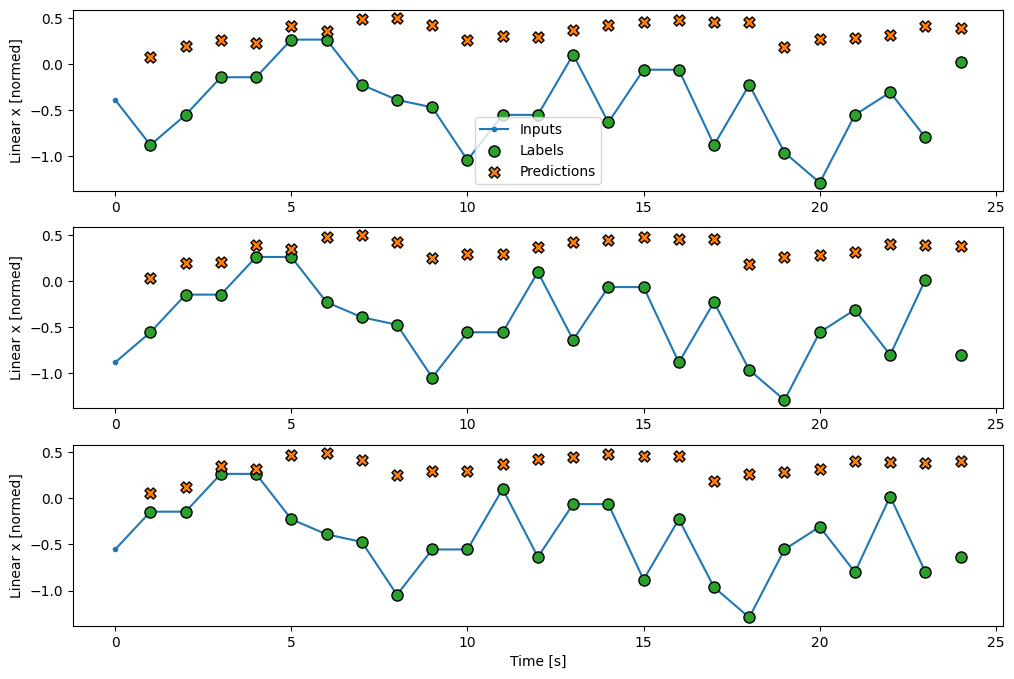

In [135]:
wide_window.plot(lstm_model)

## Residual connection

In [132]:
class ResidualWrapper(tf.keras.Model):
  def __init__(self, model):
    super().__init__()
    self.model = model

  def call(self, inputs, *args, **kwargs):
    delta = self.model(inputs, *args, **kwargs)

    # The prediction for each time step is the input
    # from the previous time step plus the delta
    # calculated by the model.
    return inputs + delta


In [133]:
%%time
residual_lstm = ResidualWrapper(
    tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(
        num_features,
        # The predicted deltas should start small.
        # Therefore, initialize the output layer with zeros.
        kernel_initializer=tf.initializers.zeros())
]))

history = compile_and_fit(residual_lstm, wide_window)

IPython.display.clear_output()
val_performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.val, return_dict=True)
performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.test, verbose=0, return_dict=True)
print()


307/307 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4950 - mean_absolute_error: 0.4122

CPU times: user 3min 39s, sys: 29.2 s, total: 4min 8s
Wall time: 1min 56s


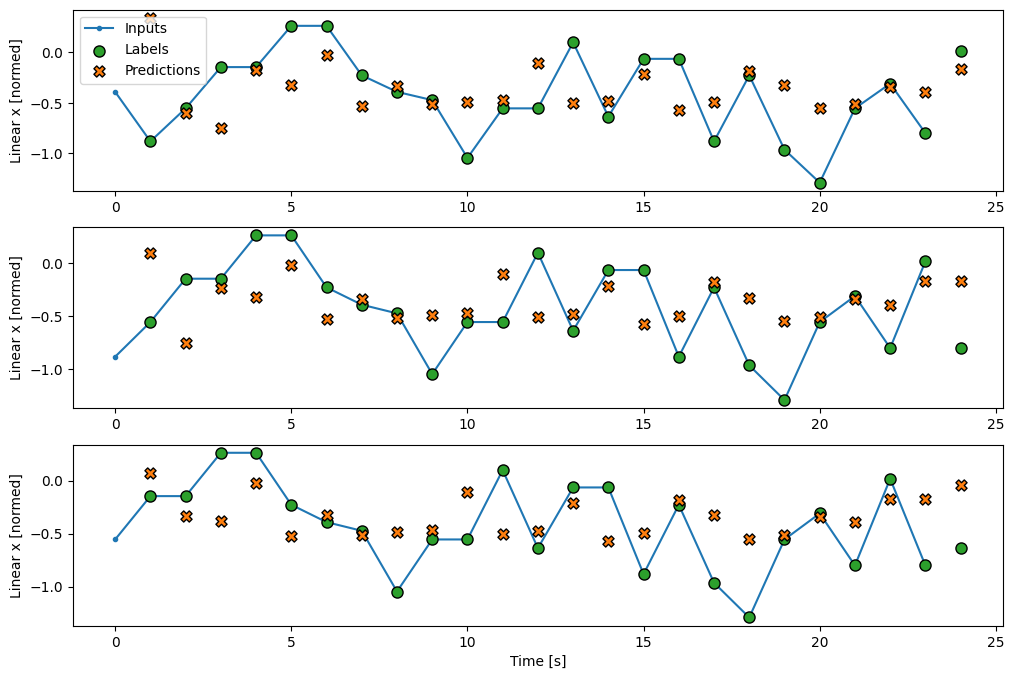

In [134]:
wide_window.plot(residual_lstm)

## Multistep models